## Summary: StackOverflow Survey Analysis

Given that the classification model using StackOverflow tags had poor F1-scores (learning just 7% on average better than the benchmark model), I decided to use a different dataset generated from StackOverflow's annual user survey. The objective was the same: to use market signals from StackOverflow data to predict which databases are most desirable and likely to be chosen.

Both datasets have a similar selection bias, that they're dependent on the complextion of the overall StackOverflow community. Alhtough I had realized this issue while analyzing the tags dataset, it is much more difficult to understand community complextion. I tried to combine the Users dataset, which includes account created, geography, and other descriptive statistics, but it did not provide enough information to explain tag counts or combinations of tags. 

However, the StackOverflow annual user survey provides a much clearer signal of community complextion, though survey/selection bias also needs to be considered. As a result, the predictability metrics are much better, and exploratory data analysis was much easier visualize and explain.

The primary insight was that the combination of current platform and desired platform choices determined the database selection. In fact, the relationship is so strong between Microsoft Azure and Microsoft SQL Server, that almost 100% of the time developers who use Microsoft Azure also desire SQL Server.

There are some caveats and important weaknesses of this insight:

  1) It is impossible to predict with 100% certainty that SQL Server will be chosen when Azure is chosen, because: 
    
    a) other cloud providers offer SQL Server, and 
    b) Azure offers more than just SQL Server as a database service.
          
  2) The explanatory power of platform choices drops dramatically for popular platforms, such as Amazon Web Services and Google Compute Platform, because: 

    a) developer types and reasons for using a platform vary much more; and 
    b) some databases are featured less prominently on other cloud platforms (Microsoft markets SQL Server much more than AWS does).
   
   
A full briefing of the analysis is below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from scipy import stats

# pipelines
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

### Overview of StackOverflow Survey Dataset

StackOverflow has been conducting an annual user survey since 2012, providing a longitudinal perspective of technology adoption, developer behaviors, wages, and hot topics impacting the developer community. 

The survey is extensive with 128 questions, some of which have as many as 16 answer choices. The survey has also steadily in popularity from just under 8000 respondents in 2012 to over 64,000 from 190 countries in 2020. As a result, it has become the largest and most important survey of the technical community in the world. Technology companies, such as Microsoft and Amazon, use StackOverflow's survey as a key source of market data about this population.

However, this dataset does have its flaws. StackOverflow promotes its survey to its base and does not provide incentives to start and finish the survey. As a result, there is a certain amount of survey bias that may not represent the overall developer population. 

Although there are multiple years of data available to the public, only the latest year's data are necessary to build predictors for desired databases. The EDA of the 2020 dataset helped to determine which features would be most relevant, followed by a further pruning of features to ensure that the model was generally applicable to the rest of the technical community. Biases and model skewing are considered along the way.

In [2]:
df_20 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2020/survey_results_public.csv')
# df_19 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2019/survey_results_public.csv')
# df_18 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2018/survey_results_public.csv')
def prettify(ax):
  ax.grid(False)
  ax.set_frame_on(False)
  ax.tick_params(top=False, bottom=False, left=False, right=False, labelbottom=False)

### Choosing relevant features

Most of the 128 questions and answer choices are irrelevant to database choices. Questions about income, Gender, Currency, Job Satisfaction, etc are obviously out of scope for this analysis. Thus, the features were cut from 128 to just 10: 
* Respont ID: for tracking indexing throughout the analysis, 
* Country: for understanding geopolitical tendencies within the data, 
* PurchaseWhat: for understanding the amount of influence a respondent in technology choices
* Undergraduate Major: secondary measure for understanding the commitment to coding and overall technical acumen,
* Hobbyist: for understanding if database choices could be influenced by project type and importance to the individual, 
* Employment: for understanding how serious one technology choices are. A second consideration relates to responsibility of technology choices. Many who are fully employed do not make their own technology choices (their employer does) 
* Developer type: for determining how much importance they put on making certain technology decisions. For instance, front-end developers are less likely to care about database choices versus backend developer or data engineers.
* Current database: for determining if their current database influences their desired database choice
* Current and desired platforms: platform choices tend to come before database choices. In other words, platform choices can dictate database choices. But does the current platform predict desired databases or do desired platforms influece desired database choices more? We shall see!

In [3]:
list(df_20)

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

In [4]:
#choosing relevant features from 2020 survey
relevant_data_20 = df_20[['Respondent', 
                          'Country',  
                          'PurchaseWhat',
                          'UndergradMajor',
                          'Hobbyist', 
                          'Employment',
                          'DevType', 
                          'DatabaseDesireNextYear', 
                          'DatabaseWorkedWith', 
                          'PlatformDesireNextYear', 
                          'PlatformWorkedWith']]
relevant_data_20.head(10)

,Respondent,Country,PurchaseWhat,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
0,1,Germany,NaN,"Computer science, computer engineering, or sof...",Yes,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...",Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows
1,2,United Kingdom,I have little or no influence,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,NaN,iOS;Kubernetes;Linux;MacOS,iOS
2,3,Russian Federation,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,I have a great deal of influence,"Computer science, computer engineering, or sof...",Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,United States,NaN,"Computer science, computer engineering, or sof...",Yes,Employed full-time,NaN,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows
5,6,Germany,I have some influence,NaN,No,Employed full-time,"Designer;Developer, front-end;Developer, mobile",NaN,NaN,Android,Android;Docker;WordPress
6,7,India,NaN,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",NaN,NaN,NaN,NaN
7,8,United States,I have some influence,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end;Developer, desktop or ente...",MongoDB,MariaDB;MySQL;Redis,iOS;Slack Apps and Integrations,Docker
8,9,Tunisia,NaN,"Computer science, computer engineering, or sof...",No,"Independent contractor, freelancer, or self-em...","Developer, full-stack",NaN,NaN,NaN,WordPress
9,10,United Kingdom,I have a great deal of influence,Mathematics or statistics,Yes,Employed full-time,"Database administrator;Developer, full-stack;D...",Microsoft SQL Server,Microsoft SQL Server,Android;Linux;Raspberry Pi;Windows,Android;Linux;Raspberry Pi;Windows


### Data Cleaning and EDA

Survey data can be very messy, especially open-ended questions. Fortunately, most of the columns were relatively clean, but some needed to be split, hot-encoded, and transformed for the model. Each step has a more detailed explanation below.

In [5]:
relevant_data_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              64461 non-null  int64 
 1   Country                 64072 non-null  object
 2   PurchaseWhat            39364 non-null  object
 3   UndergradMajor          50995 non-null  object
 4   Hobbyist                64416 non-null  object
 5   Employment              63854 non-null  object
 6   DevType                 49370 non-null  object
 7   DatabaseDesireNextYear  44070 non-null  object
 8   DatabaseWorkedWith      49537 non-null  object
 9   PlatformDesireNextYear  50605 non-null  object
 10  PlatformWorkedWith      53843 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.4+ MB


### Some insights about country of origin

Country of origin could provide interesting insights about respondents and their answer choices. Considerations include: a) access to technology and education, b) spoken language, c) affordability, and d) representation of overall population (or trying to draw comparisons between the StackOverflow community and the global technical community).

One of the first insights provided by doing a simple count was the seemingly over representation of US and India populations. The StackOverflow community is also highly skewed towards English speaking countries, given that StackOverflow questions and answers are not translated. Therefore, this model may not be a good proxy for the overall technical community, suggesting that it could predict desired databases for the StackOverflow community, but may not be as predictive in 'real world' scenarios.

Respondents from the US, India, UK, Germany and Canada constitute almost 50% of all respondents. This makeup would suggest a good predictor for desired databases, given that the weight for each would be significant. However, respondents from the other 185 countries would have much less significance or 'explainability'. Pruning the decision tree became much easier with this implication in mind.

<AxesSubplot:title={'center':'Number of Respondents from Countries'}>

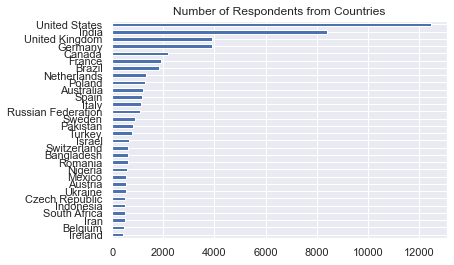

In [6]:
#counting number of respondents per country
country_20 = relevant_data_20['Country'].value_counts()
top_country_20 = country_20.head(30).sort_values(ascending = True)
top_country_20.plot(kind = 'barh', title = 'Number of Respondents from Countries')

### Respondent types

Respondents could choose multiple answer choices, making it difficult to ascertain their primary job function. For instance, many of the respondents who selected "Developer, back-end" and "Developer, front-end", would have also chosen "Developer, full-stack". Therefore, there are probably many more respondent types who would self-identify as "Developer, full-stack" than what is represented in the data. 

In order to mitigate this selection bias, the column was split into columns for each answer choice and summed to show which answer choice was chosen most frequently.

<AxesSubplot:title={'center':'Number of Developers per Devtype'}>

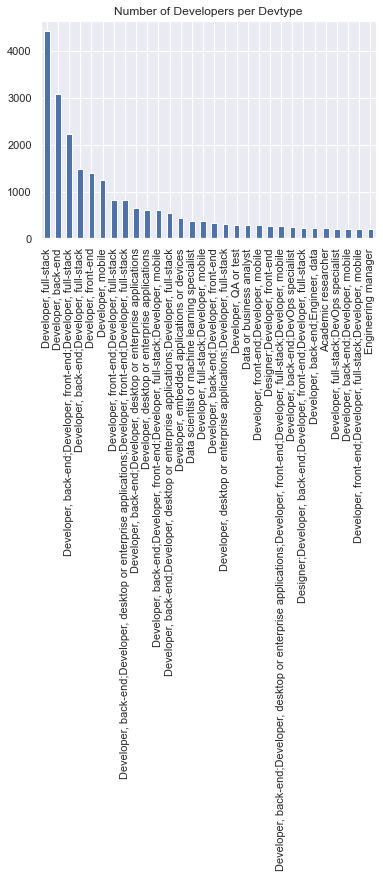

In [7]:
devtype_20 = relevant_data_20['DevType'].value_counts()
devtype_20 = devtype_20.head(30).sort_values(ascending = False)
devtype_20.plot(kind = 'bar', title = 'Number of Developers per Devtype')

In [8]:
#split into columns for each answer choice.

def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in col_series[col_series.notnull()].iteritems():
        # Break each value into list of options
        for option in value.split(';'):
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Mark the value in the option column as True
            result_df.at[idx, option] = True
    return result_df[options]

In [9]:
#sum each answer choice for DevType
devtype_df = split_multicolumn(relevant_data_20['DevType'])

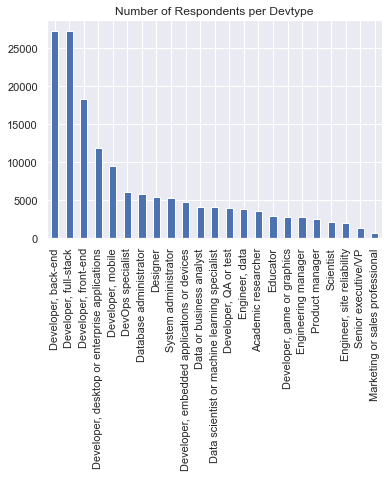

In [10]:
dev_type_totals = devtype_df.sum().sort_values(ascending = False)


from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

pps = dev_type_totals.plot(kind = 'bar', title = 'Number of Respondents per Devtype')


plt.show()

### Decision Makers

Respondent types should inform the model significantly given that they have direct control over the technologies that they use...or at least that is the assumption. There are many instances, especially in large organizations, when only managers have direct decision making power. That is changing, due to the cloud, but decision making still has more significance in the model than direct usage. Nevertheless, this model incorporates both dimensions.

/Users/bens_mac/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


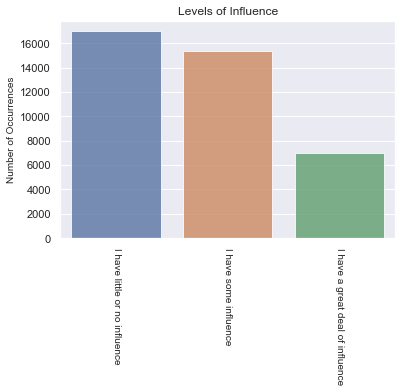

In [11]:
purchasewhat_totals = relevant_data_20['PurchaseWhat'].value_counts()

# purchasewhat_totals = purchasewhat.sum().sort_values(ascending = False)

sns.barplot(purchasewhat_totals.index, purchasewhat_totals.values, alpha=0.8)
plt.title('Levels of Influence')
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(rotation=270,fontsize = 10, wrap=False)
plt.show()

### Cross-tabs for quick insights

There are obvious relationships between some of the features that should be explored. For instance, the number of developers who are also decision makers would be good to know. It would also be helpful to know what percentage of decision makers chose certain platforms.

As can be seen below, full-stack developers had the most influence over purchases among the top ten DevTypes in terms of absolute numbers and percentages. Given that full-stack developers make up a large majority of the overall sample, we can assume that this category would be influential in the model.

In [12]:
DevType_by_PurchaseWhat = pd.crosstab(relevant_data_20['DevType'], relevant_data_20['PurchaseWhat'])
Top_10_Decision_Makers = DevType_by_PurchaseWhat.sort_values(by = 'I have some influence', 
                                                            ascending = False).head(10)

Top_10_Decision_Makers

PurchaseWhat,I have a great deal of influence,I have little or no influence,I have some influence
DevType,,,
"Developer, full-stack",441,1760,1301
"Developer, back-end",202,1451,853
"Developer, back-end;Developer, front-end;Developer, full-stack",225,895,688
"Developer, back-end;Developer, full-stack",129,628,467
"Developer, mobile",134,453,379
"Developer, front-end",97,575,337
"Developer, front-end;Developer, full-stack",79,341,266
"Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack",66,362,254
"Developer, back-end;Developer, front-end;Developer, full-stack;Developer, mobile",68,197,206


We can also see that those who have some or great influence over technology purchases would chose particular databases. As you can see, PostgreSQL had the highest absolute numbers, but surprisingly Microsoft SQL Server had the highest weighted percentage of respondents who have some or great influence of purchases. This may reflect the strong interest that Microsoft has seen for its commercial database.

In [13]:
Database_Desire_NextYear = pd.crosstab(relevant_data_20['DatabaseDesireNextYear'], relevant_data_20['PurchaseWhat'])
Top_10_Decision_Makers_Databases = Database_Desire_NextYear.sort_values(by = 'I have some influence', 
                                                            ascending = False).head(10)

Top_10_Decision_Makers_Databases = Top_10_Decision_Makers_Databases.reset_index()

Top_10_Decision_Makers_Databases

PurchaseWhat,DatabaseDesireNextYear,I have a great deal of influence,I have little or no influence,I have some influence
0,PostgreSQL,325,708,741
1,Microsoft SQL Server,244,730,563
2,MongoDB,160,489,378
3,MySQL,157,402,348
4,PostgreSQL;Redis,145,207,265
5,SQLite,108,258,233
6,Firebase,95,240,203
7,PostgreSQL;SQLite,103,175,198
8,MongoDB;PostgreSQL,54,200,161
9,Elasticsearch;PostgreSQL;Redis,80,105,148


Another important consideration is how important the application or workload that the developer may assign, as that importance may also dictate the type of database the respondent uses.

In [14]:
DevType_Employment = pd.crosstab(relevant_data_20['DevType'], relevant_data_20['Employment'])
Top_10_DevTypes_Employment = DevType_Employment.sort_values(by = 'Employed full-time', 
                                                            ascending = False).head(10)

Top_10_DevTypes_Employment

Employment,Employed full-time,Employed part-time,"Independent contractor, freelancer, or self-employed","Not employed, but looking for work"
DevType,,,,
"Developer, full-stack",3786,137,356,145
"Developer, back-end",2721,99,163,103
"Developer, back-end;Developer, front-end;Developer, full-stack",1886,82,183,76
"Developer, back-end;Developer, full-stack",1300,31,103,42
"Developer, front-end",1145,64,91,101
"Developer, mobile",1075,33,90,53
"Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack",721,16,51,25
"Developer, front-end;Developer, full-stack",715,23,61,31
"Developer, back-end;Developer, desktop or enterprise applications",565,29,39,17


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Employed full-time'),
  Text(1, 0, 'Employed part-time'),
  Text(2, 0, 'Independent contractor, freelancer, or self-employed'),
  Text(3, 0, 'Not employed, but looking for work')])

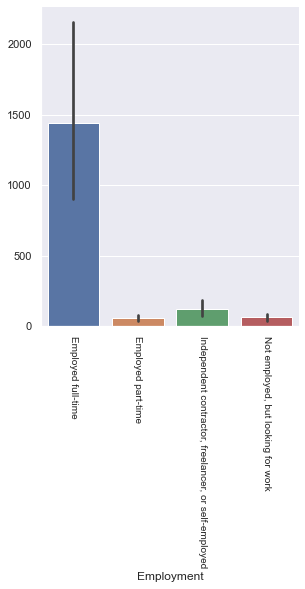

In [15]:
g = sns.catplot(data=Top_10_DevTypes_Employment, kind="bar")
plt.xticks(rotation=270,fontsize = 10, wrap=False)

# b = sns.catplot(x=Top_10_DevTypes_Employment)
# b.axes.set_title("Title",fontsize=50)
# b.set_xlabel("X Label",fontsize=30)
# b.set_ylabel("Y Label",fontsize=20)
# # b.tick_params(labelsize=5)
# sns.plt.show()

With these insights in mind, let's take a closer look at how certain features predict desired database choices. However there is a lot of clean up and data transformation (one-hot encoding) to make this data ready for Decision Tree classifier.

These four features needed to be split and encoded:

* Current database
* Current platform
* Desired platform
* DevType

The label, Desired databases, also needed to be split and encoded.

In [16]:
relevant_data_20_clean = relevant_data_20.dropna()

In [17]:
df = pd.concat([relevant_data_20_clean, relevant_data_20_clean['DatabaseWorkedWith'].str.split(';', expand=True)], axis=1)

In [18]:
df = df.rename(columns = {0: "CurrentDB0",
                     1: "CurrentDB1",
                     2: "CurrentDB2",
                     3: "CurrentDB3",
                     4: "CurrentDB4", 
                     5:"CurrentDB5",
                     6:"CurrentDB6",
                     7:"CurrentDB7",
                     8:"CurrentDB8",
                     9:"CurrentDB9",
                     10:"CurrentDB10",
                     11:"CurrentDB11",
                     12:"CurrentDB12",
                     13:"CurrentDB13",})

In [19]:
df = pd.concat([df, df['DatabaseDesireNextYear'].str.split(';', expand=True)], axis=1)

In [20]:
df = df.rename(columns = {0: "DesiredDB0",
                     1: "DesiredDB1",
                     2: "DesiredDB2",
                     3: "DesiredDB3",
                     4: "DesiredDB4", 
                     5:"DesiredDB5",
                     6:"DesiredB6",
                     7:"DesiredDB7",
                     8:"DesiredDB8",
                     9:"DesiredDB9",
                     10:"DesiredDB10",
                     11:"DesiredDB11",
                     12:"DesiredDB12",
                     13:"DesiredDB13",})

In [21]:
df = pd.concat([df, df['PlatformDesireNextYear'].str.split(';', expand=True)], axis=1)

In [22]:
df = df.rename(columns = {0: "DesiredPlatform0",
                     1: "DesiredPlatform1",
                     2: "DesiredPlatform2",
                     3: "DesiredPlatform3",
                     4: "DesiredPlatform4", 
                     5:"DesiredPlatform5",
                     6:"DesiredPlatform6",
                     7:"DesiredPlatform7",
                     8:"DesiredPlatform8",
                     9:"DesiredPlatform9",
                     10:"DesiredPlatform10",
                     11:"DesiredPlatform11",
                     12:"DesiredPlatform12",
                     13:"DesiredPlatform13",
                    14:"DesiredPlatform14",
                     15:"DesiredPlatform15",                                 
                                                           })

In [23]:
df = pd.concat([df, df['PlatformWorkedWith'].str.split(';', expand=True)], axis=1)

In [24]:
df = df.rename(columns = {0: "CurrentPlatform0",
                     1: "CurrentPlatform1",
                     2: "CurrentPlatform2",
                     3: "CurrentPlatform3",
                     4: "CurrentPlatform4", 
                     5:"CurrentPlatform5",
                     6:"CurrentPlatform6",
                     7:"CurrentPlatform7",
                     8:"CurrentPlatform8",
                     9:"CurrentPlatform9",
                     10:"CurrentPlatform10",
                     11:"CurrentPlatform11",
                     12:"CurrentPlatform12",
                     13:"CurrentPlatform13",
                    14:"CurrentPlatform14",
                     15:"CurrentPlatform15",                                 
                                                           })

In [25]:
df = pd.concat([df, df['DevType'].str.split(';', expand=True)], axis=1)

In [26]:
df = df.rename(columns = {0: "DevType0",
                          1: "DevType1",
                          2: "DevType2",
                          3: "DevType3",
                          4: "DevType4",
                          5: "DevType5",
                          6: "DevType6",
                          7: "DevType7",
                          8: "DevType8",
                          9: "DevType9",
                          10: "DevType10",
                          11: "DevType11",
                          12: "DevType12",
                          13: "DevType13",
                          14: "DevType14",
                          15: "DevType15",
                          16: "DevType16",
                          17: "DevType17",
                          18: "DevType18",
                          19: "DevType19",
                          20: "DevType20",
                          21: "DevType21",
                          22: "DevType22"  
    
})

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24805 entries, 7 to 64152
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              24805 non-null  int64 
 1   Country                 24805 non-null  object
 2   PurchaseWhat            24805 non-null  object
 3   UndergradMajor          24805 non-null  object
 4   Hobbyist                24805 non-null  object
 5   Employment              24805 non-null  object
 6   DevType                 24805 non-null  object
 7   DatabaseDesireNextYear  24805 non-null  object
 8   DatabaseWorkedWith      24805 non-null  object
 9   PlatformDesireNextYear  24805 non-null  object
 10  PlatformWorkedWith      24805 non-null  object
 11  CurrentDB0              24805 non-null  object
 12  CurrentDB1              18981 non-null  object
 13  CurrentDB2              12646 non-null  object
 14  CurrentDB3              7494 non-null   object
 15  Cu

In order to build a simple model to see if this model has any efficacy, we'll start with a toy and evaluate it with F1 scores and accuracy metrics. The toy consists of the first selected answer choice of each feature in question (DevType, Current Database, Desired Database, Desired Platform, and Current Platform).

Country was also included in the first iteration.

In [28]:
df_toy = df[['Country','DevType0','CurrentDB0', 'DesiredDB0', 'DesiredPlatform0', 'CurrentPlatform0']]

In [29]:
df_toy.head()

,Country,DevType0,CurrentDB0,DesiredDB0,DesiredPlatform0,CurrentPlatform0
7,United States,"Developer, back-end",MariaDB,MongoDB,iOS,Docker
9,United Kingdom,Database administrator,Microsoft SQL Server,Microsoft SQL Server,Android,Android
10,United Kingdom,"Developer, back-end",Firebase,Firebase,AWS,AWS
13,United States,"Developer, desktop or enterprise applications",Firebase,Firebase,Google Cloud Platform,Google Cloud Platform
17,United States,"Developer, back-end",Elasticsearch,Elasticsearch,Linux,AWS


In [30]:
def count_db(df_toy, column_string,db_name):
    '''Count the number of current or desired databases'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == db_name:
            counter += 1
    return counter

In [31]:
Cur_MySQL = count_db(df_toy, "CurrentDB0","MySQL")
Cur_PostgreSQL = count_db(df_toy, "CurrentDB0","PostgreSQL")
Cur_Microsoft_SQL_Server = count_db(df_toy, "CurrentDB0","Microsoft SQL Server")
Cur_SQLite = count_db(df_toy, "CurrentDB0","SQLite")
Cur_MongoDB = count_db(df_toy, "CurrentDB0","MongoDB")
Cur_Redis = count_db(df_toy, "CurrentDB0","Redis")
Cur_MariaDB = count_db(df_toy, "CurrentDB0","MariaDB")
Cur_Oracle = count_db(df_toy, "CurrentDB0","Oracle")
Cur_Firebase = count_db(df_toy, "CurrentDB0","Firebase")
Cur_Elasticsearch = count_db(df_toy, "CurrentDB0","Elasticsearch")
Cur_DynamoDB = count_db(df_toy, "CurrentDB0","DynamoDB")
Cur_Cassandra = count_db(df_toy, "CurrentDB0","Cassandra")
Cur_IBM_DB2 = count_db(df_toy, "CurrentDB0","IBM DB2")
Cur_Couchbase= count_db(df_toy, "CurrentDB0","Couchbase")

Current_DBs = [
Cur_MySQL,
Cur_PostgreSQL,
Cur_Microsoft_SQL_Server,
Cur_SQLite,
Cur_MongoDB,
Cur_Redis,
Cur_MariaDB,
Cur_Oracle,
Cur_Firebase,
Cur_Elasticsearch,
Cur_DynamoDB,
Cur_Cassandra,
Cur_IBM_DB2,
Cur_Couchbase
]

Note that Microsoft SQL Server was the first answer choice most selected by the sample (see graph below), but that does not mean that is it the most selected overall. When looking at the total times each answer choice was selected, MySQL had the highest count. Therefore, this toy model will need to include all selections in order to make it more accurate. 

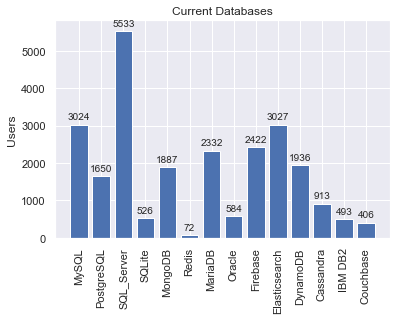

In [32]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Databases')

# ax.bar(x - width/2, Current_DBs, width, label='Current_DBs')

pps = plt.bar(labels,Current_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [33]:
Des_MySQL = count_db(df_toy, "DesiredDB0","MySQL")
Des_PostgreSQL = count_db(df_toy, "DesiredDB0","PostgreSQL")
Des_Microsoft_SQL_Server = count_db(df_toy, "DesiredDB0","Microsoft SQL Server")
Des_SQLite = count_db(df_toy, "DesiredDB0","SQLite")
Des_MongoDB = count_db(df_toy, "DesiredDB0","MongoDB")
Des_Redis = count_db(df_toy, "DesiredDB0","Redis")
Des_MariaDB = count_db(df_toy, "DesiredDB0","MariaDB")
Des_Oracle = count_db(df_toy, "DesiredDB0","Oracle")
Des_Firebase = count_db(df_toy, "DesiredDB0","Firebase")
Des_Elasticsearch = count_db(df_toy, "DesiredDB0","Elasticsearch")
Des_DynamoDB = count_db(df_toy, "DesiredDB0","DynamoDB")
Des_Cassandra = count_db(df_toy, "DesiredDB0","Cassandra")
Des_IBM_DB2 = count_db(df_toy, "DesiredDB0","IBM DB2")
Des_Couchbase= count_db(df_toy, "DesiredDB0","Couchbase")

Desired_DBs = [
Des_MySQL,
Des_PostgreSQL,
Des_Microsoft_SQL_Server,
Des_SQLite,
Des_MongoDB,
Des_Redis,
Des_MariaDB,
Des_Oracle,
Des_Firebase,
Des_Elasticsearch,
Des_DynamoDB,
Des_Cassandra,
Des_IBM_DB2,
Des_Couchbase
]


#Check to see if total rows of this series with total rows of the toy dataset.
sum = 0
for i in Desired_DBs:
    sum += i
print(sum)

24805


Note that database popularity is highly fickle (see graph below). There was no difference in sequence or list composition, so there is in no survey bias. The differences in current databases and desired databases are highly divergent, postitively and negatively.

This is important to note, as the decision tree may lose some fidelity due to these fluctuations.

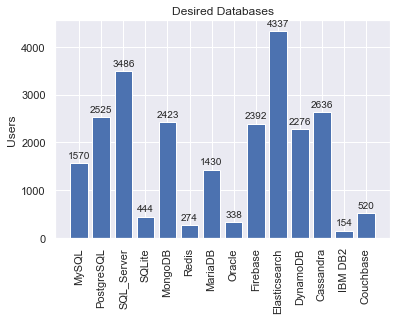

In [34]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Databases')

pps = plt.bar(labels,Desired_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [35]:
def count_platforms(df_toy, column_string,platform_name):
    '''Count the number of desired platforms'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == platform_name:
            counter += 1
    return counter


In [36]:
Linux = count_platforms(df_toy, "DesiredPlatform0","Linux")
Windows = count_platforms(df_toy, "DesiredPlatform0","Windows")
Docker = count_platforms(df_toy, "DesiredPlatform0","Docker")
AWS = count_platforms(df_toy, "DesiredPlatform0","AWS")
Android = count_platforms(df_toy, "DesiredPlatform0","Android")
MacOS = count_platforms(df_toy, "DesiredPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "DesiredPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "DesiredPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "DesiredPlatform0","WordPress")
Google = count_platforms(df_toy, "DesiredPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "DesiredPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "DesiredPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "DesiredPlatform0","Heroku")
Arduino= count_platforms(df_toy, "DesiredPlatform0","Arduino")
Slack = count_platforms(df_toy, "DesiredPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "DesiredPlatform0","IBM Cloud or Watson")

Desired_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Desired_Platforms:
    sum += i
print(sum)


24805


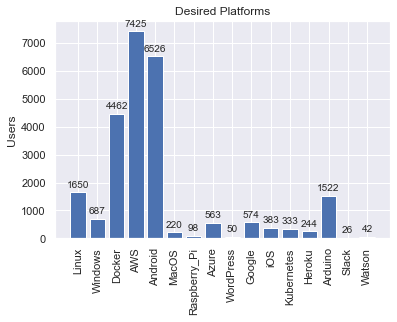

In [37]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Platforms')

pps = plt.bar(labels,Desired_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [38]:
#PlatformWorkedWith0

Linux = count_platforms(df_toy, "CurrentPlatform0","Linux")
Windows = count_platforms(df_toy, "CurrentPlatform0","Windows")
Docker = count_platforms(df_toy, "CurrentPlatform0","Docker")
AWS = count_platforms(df_toy, "CurrentPlatform0","AWS")
Android = count_platforms(df_toy, "CurrentPlatform0","Android")
MacOS = count_platforms(df_toy, "CurrentPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "CurrentPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "CurrentPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "CurrentPlatform0","WordPress")
Google = count_platforms(df_toy, "CurrentPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "CurrentPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "CurrentPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "CurrentPlatform0","Heroku")
Arduino= count_platforms(df_toy, "CurrentPlatform0","Arduino")
Slack = count_platforms(df_toy, "CurrentPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "CurrentPlatform0","IBM Cloud or Watson")

Current_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Current_Platforms:
    sum += i
print(sum)

24805


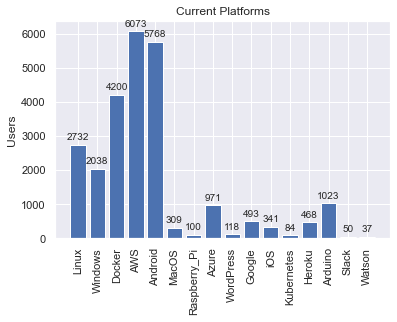

In [39]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Platforms')

pps = plt.bar(labels,Current_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

The initial model included "Country" as a feature, but the feature importance analysis showed that 'by country' features were not significant and just cluttered the analysis. Thus, I dropped it from the project's feature list.

In [40]:
#One-hot encoding and training dataset for predicting desired databases

X_database = pd.get_dummies(df_toy, columns= ['DevType0','CurrentDB0', 'DesiredPlatform0','CurrentPlatform0'])
X_database = X_database.drop(['Country', 'DesiredDB0'], axis = 1)
y_desired_database = df_toy['DesiredDB0']

In [41]:
X_database.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24805 entries, 7 to 64152
Data columns (total 69 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   DevType0_Academic researcher                            24805 non-null  uint8
 1   DevType0_Data or business analyst                       24805 non-null  uint8
 2   DevType0_Data scientist or machine learning specialist  24805 non-null  uint8
 3   DevType0_Database administrator                         24805 non-null  uint8
 4   DevType0_Designer                                       24805 non-null  uint8
 5   DevType0_DevOps specialist                              24805 non-null  uint8
 6   DevType0_Developer, QA or test                          24805 non-null  uint8
 7   DevType0_Developer, back-end                            24805 non-null  uint8
 8   DevType0_Developer, desktop or enterprise applications  

## Model Fit and Evaluation
Now that the features and labels have been defined, we can use a Decision Tree classifier to fit and determine which features have the most predictive influence within the model. 

When fitting the training data against all of the potential desired databases, the model is very inaccurate. The outcomes are too varied and thus the decision tree has difficulty in predicting which features are most influential.

Therefore, I chose the top six most highly desired databases as labels to show how each has slightly different accuracy scores based on the predictors.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_database,y_desired_database, test_size = .2)
clf = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 10) 
score = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
score.mean()

0.42345375091411397

In [58]:
#Labels for top desired databases


def desired_database_y(df_toy, column_string, label):
    
    label_name = []
    for i in df_toy[column_string]:
        if i == label:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name

MySQL_y = (desired_database_y(df_toy, 'DesiredDB0', "MySQL"))
Elasticsearch_y = (desired_database_y(df_toy, 'DesiredDB0', "Elasticsearch"))
SQL_Server_y = (desired_database_y(df_toy, 'DesiredDB0', "Microsoft SQL Server"))
PostgreSQL_y = (desired_database_y(df_toy, 'DesiredDB0', "PostgreSQL"))
Firebase_y = (desired_database_y(df_toy, 'DesiredDB0', "Firebase"))
DynamoDB_y = (desired_database_y(df_toy, 'DesiredDB0', "DynamoDB"))

np.count_nonzero(SQL_Server_y) #Check to see if the total count of a desired database is the same as the toy dataset.

3486

In [59]:
#Create function to make it easier to calculate means for accuracy scores for top labels.

def mean_accuracy_scores(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)
    clf = DecisionTreeClassifier()
    cv = StratifiedKFold(n_splits = 10) 
    scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
    return scores.mean()

print(f"MySQL accuracy score: {mean_accuracy_scores(X_database, MySQL_y)}")
print(f"Elastic accuracy score: {mean_accuracy_scores(X_database, Elasticsearch_y)}")
print(f"SQL Server accuracy score: {mean_accuracy_scores(X_database, SQL_Server_y)}")
print(f"PostgresSQL accuracy score: {mean_accuracy_scores(X_database, PostgreSQL_y)}")
print(f"Firebase accuracy score: {mean_accuracy_scores(X_database, Firebase_y)}")
print(f"DynamoDB accuracy score: {mean_accuracy_scores(X_database, DynamoDB_y)}")

MySQL accuracy score: 0.9316167120338019
Elastic accuracy score: 0.8246817867880069
SQL Server accuracy score: 0.8877740564312993
PostgresSQL accuracy score: 0.9032457899975626
Firebase accuracy score: 0.9067233840497279
DynamoDB accuracy score: 0.9167005312017551


# Analysis and Explanation

Accuracy scores for the top six show a trending quality that suggests the more popular the desired database the more likely it would have a lower accuracy score. But it goes slightly deeper, as SQL Server actually loses popularity between existing and desired instances.

The probable cause is the difference in number of current users from those who desire ElasticSearch as their next database. But the descrepancy between existing and desired instances of SQL Server is due to fewer people desiring it than those who have it. This descrepancy is by far the highest among Current DBs and Desired DBs for ElasticSearch. 

The opposite could be said for SQL Server. Essentially, mostly existing users desire this platform. Thus, the probability that an existing SQL Server user would choose SQL Server is high but no other existing database user would do the same. See table below.

In order to go deeper into the discrepancies, see the confusion matrix and feature significance graphs below.

In [60]:
Current_Desired_DBs = pd.crosstab(df_toy['CurrentDB0'], df_toy['DesiredDB0'])
Current_Desired_DBs.head(10).sort_values(by = 'Elasticsearch', ascending = False)

DesiredDB0,Cassandra,Couchbase,DynamoDB,Elasticsearch,Firebase,IBM DB2,MariaDB,Microsoft SQL Server,MongoDB,MySQL,Oracle,PostgreSQL,Redis,SQLite
CurrentDB0,,,,,,,,,,,,,,
Elasticsearch,437,43,177,1672,86,3,73,88,112,56,13,213,42,12
Microsoft SQL Server,379,77,264,678,290,16,85,2901,339,111,56,259,46,32
MySQL,219,45,143,337,234,5,107,57,412,1069,24,305,27,40
MariaDB,179,47,114,327,185,7,966,85,149,51,18,167,18,19
MongoDB,186,38,115,281,105,3,29,21,833,73,9,157,21,16
Firebase,189,53,174,271,1214,5,61,91,176,59,12,80,21,16
DynamoDB,234,19,1037,227,65,4,38,52,81,40,2,111,22,4
Cassandra,487,26,73,118,21,4,23,28,42,20,7,50,11,3
Couchbase,67,136,22,59,23,0,7,16,29,7,1,33,5,1


## Comparing desirability of specific databases

Elasticsearch and Microsoft SQL Server are the most desirable of the bunch, but they're coming from different origins, where Elasticsearch is attracting far more new users than other databases and SQL Server is actually losing users.

Also note in the Feature Importances graphs that both have "CurrentDB0_ ..." as the overwhelming influencer, but Elasticsearch has far more influential features than SQL Server. This suggests that these additional influential features will lower the overall accuracy of the model, as they essentially 'muddy' the waters.

### Elasticsearch

In [61]:
y = Elasticsearch_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


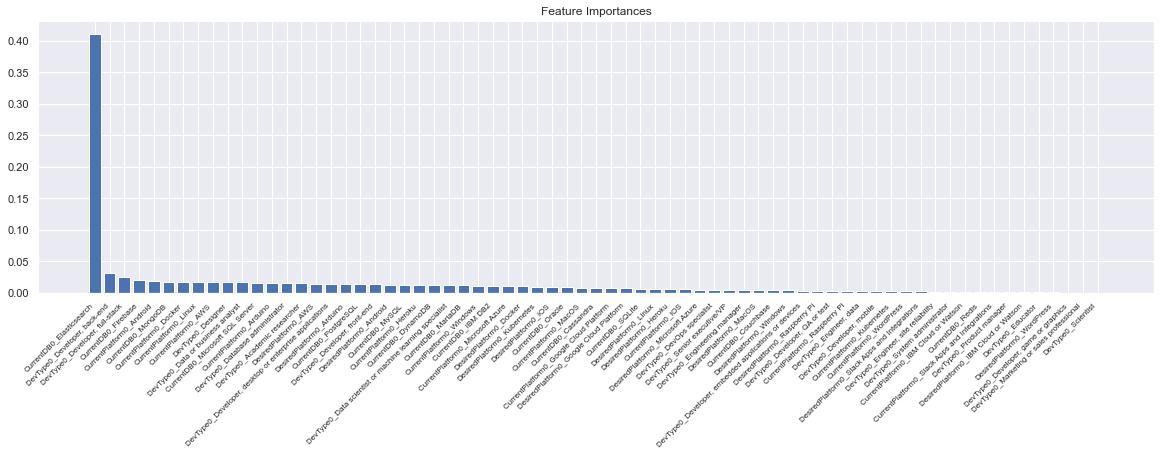

In [62]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")

### Microsoft SQL Server

In [63]:
y = SQL_Server_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


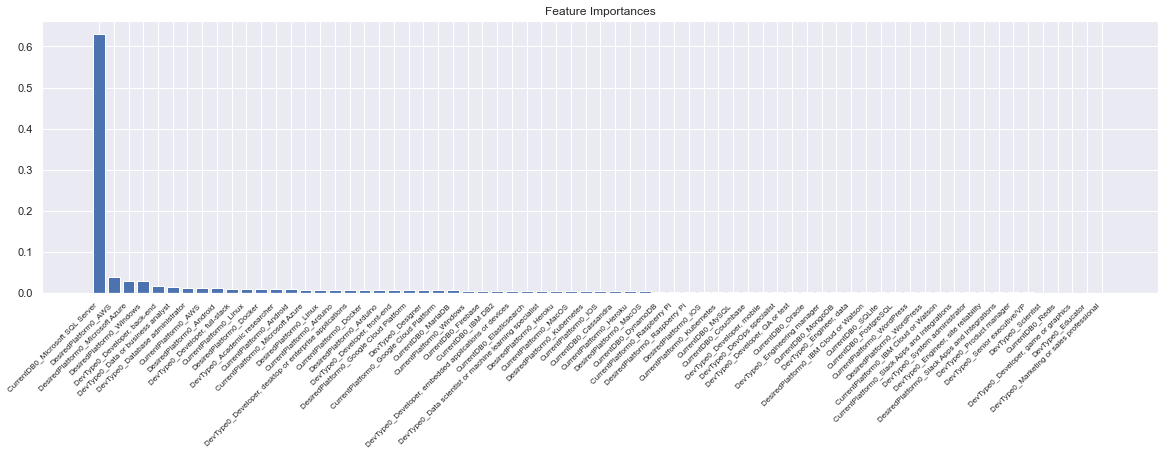

In [64]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")

### MySQL

In [65]:
y = MySQL_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


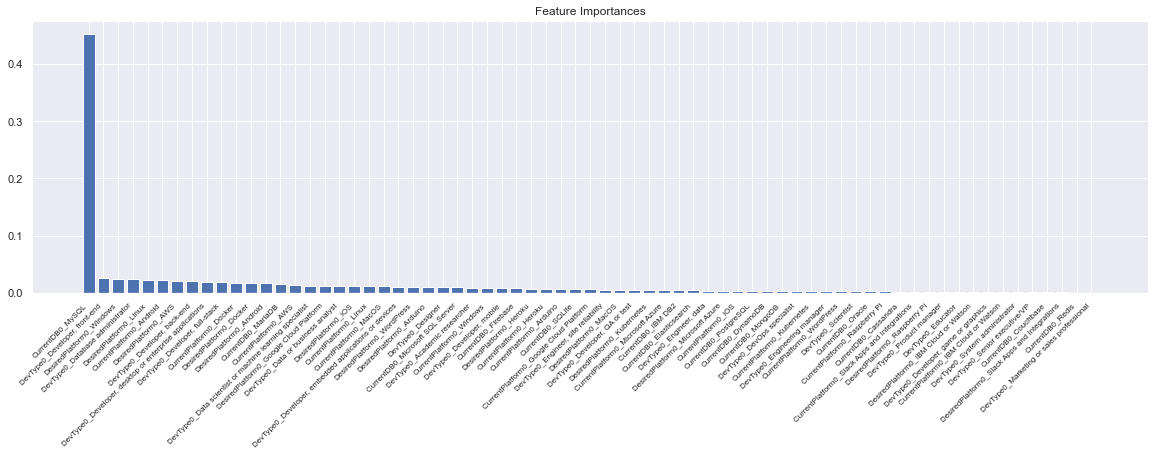

In [66]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")

### Postgresql

In [68]:
y = PostgreSQL_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


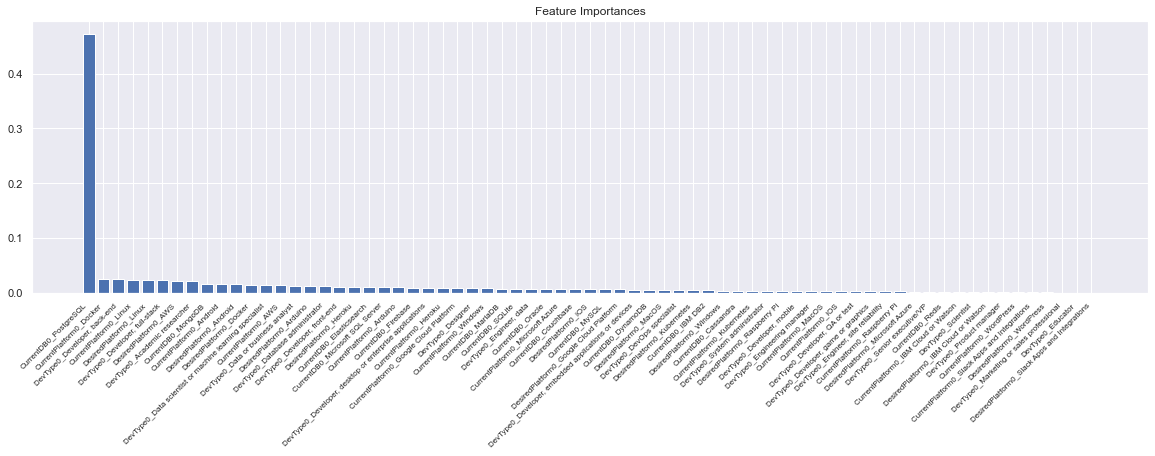

In [69]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")

### DynamoDB

In [70]:
y = DynamoDB_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


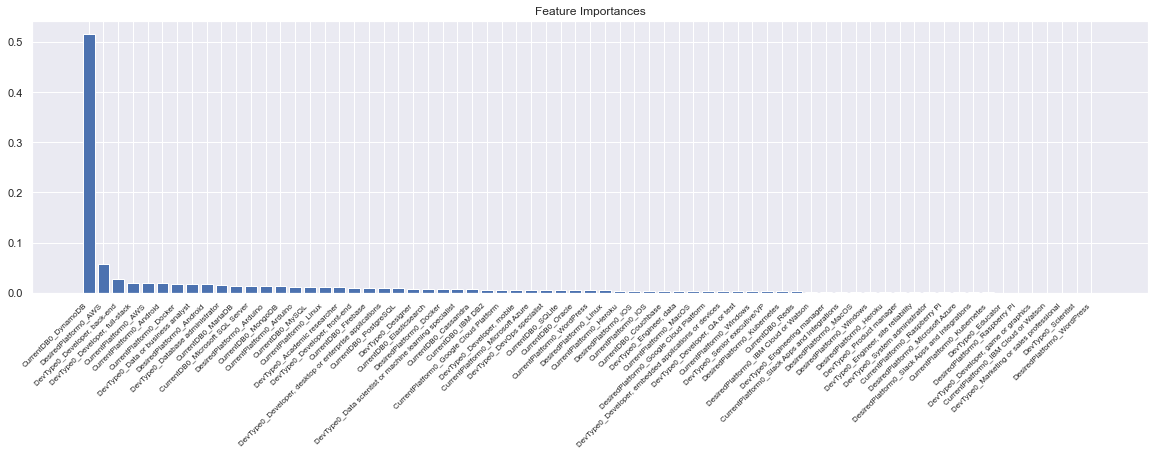

In [71]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")

### Firebase

In [72]:
y = Firebase_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)


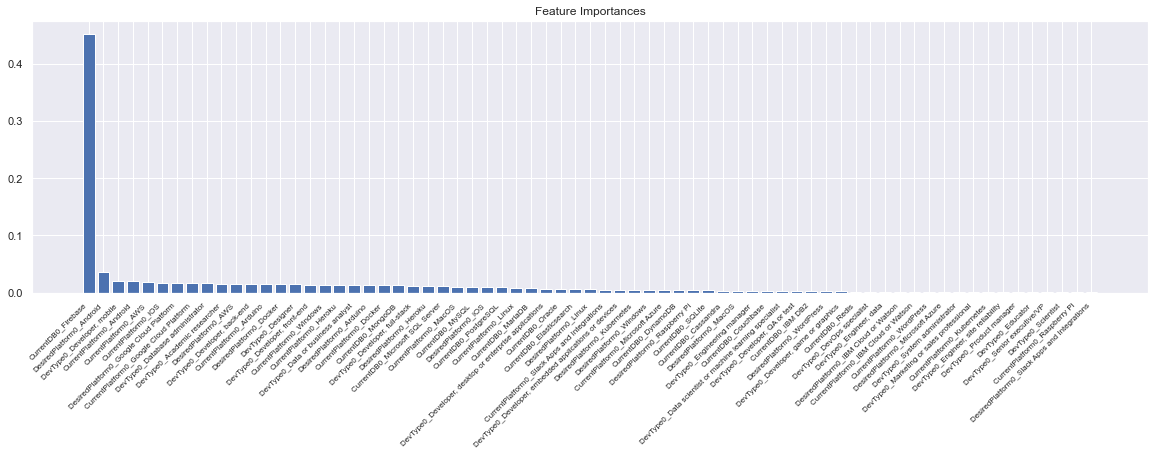

In [73]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''
predictor_names = X_database.columns.tolist()
    
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

#Save figure to save to computer/laptop
fig.savefig("Feature_Explosion")